# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [47]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [48]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 8  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [50]:
# def plot_learned_hamiltonian_cross_sections(model, a, spacing, INVERT_MODE, dim):
#     xi = np.linspace(-a, a, spacing)
#     p_grid = np.zeros((xi.size, dim))
#     p_grid[:, 0] = xi
    
#     y_inverted_points = invert(p_grid, model, INVERT_MODE)
#     b_values = 0.5 * euclid_norm_sq(y_inverted_points)
    
#     h_est = inner_prod(p_grid, y_inverted_points) - b_values
    
#     h_true = 0.5 * euclid_norm_sq(p_grid)
    
#     plt.figure(figsize=(6, 5))
#     plt.plot(xi, h_est, "-", ms=5, label="Learned H")
#     plt.plot(xi, h_true, "--", ms=5, label="True H")
#     plt.grid(True)
#     plt.title(f"Hamiltonian $H(p_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$p_1$')
#     plt.ylabel('$H(p_1,0,...)$')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# def plot_learned_hamiltonian_cross_sections(model, a, spacing, INVERT_MODE, dim):
#     xi = np.linspace(-a, a, spacing)
#     p_grid = np.zeros((xi.size, dim))
#     p_grid[:, 0] = xi
    
#     y_inverted_points = invert(p_grid, model, INVERT_MODE)
#     b_values = 0.5 * euclid_norm_sq(y_inverted_points)
    
#     h_est = inner_prod(p_grid, y_inverted_points) - b_values
    
#     h_true = 0.5 * euclid_norm_sq(p_grid)
    
#     plt.figure(figsize=(6, 5))
#     plt.plot(xi, h_est, "-", ms=5, label="Learned H")
#     plt.plot(xi, h_true, "--", ms=5, label="True H")
#     plt.grid(True)
#     plt.title(f"Hamiltonian $H(p_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$p_1$')
#     plt.ylabel('$H(p_1,0,...)$')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [51]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


--- Generating Training Data for Concave Quadratic Prior ---
Generated training data: y_j_exp_tensor shape torch.Size([20000, 8]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [52]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [53]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 1728.375244140625
iteration 500 loss 57.572044372558594
iteration 0 loss 50.51555252075195
iteration 500 loss 47.28076171875
iteration 1000 loss 45.34235763549805
iteration 1500 loss 43.430179595947266
iteration 2000 loss 41.17241287231445
iteration 2500 loss 38.43479919433594
iteration 3000 loss 35.02617645263672
iteration 3500 loss 30.602556228637695
iteration 4000 loss 24.547718048095703
iteration 4500 loss 16.213048934936523
iteration 5000 loss 8.145822525024414
iteration 5500 loss 4.264395713806152
iteration 6000 loss 2.9753756523132324
iteration 6500 loss 2.281151533126831
iteration 7000 loss 1.807081699371338
iteration 7500 loss 1.4596138000488281
iteration 8000 loss 1.1710397005081177
iteration 8500 loss 0.955479085445404
iteration 9000 loss 0.7963968515396118
iteration 9500 loss 0.6797832250595093
iteration 10000 loss 0.5909466743469238
iteration 10500 loss 0.5145532488822937
iteration 11000 loss 

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss 10.042123794555664
loss -42.049468994140625
loss -75.94782257080078
loss -91.65791320800781
loss -95.81246185302734
loss -96.45928955078125
loss -96.63872528076172
loss -96.70320129394531
loss -96.72949981689453
loss -96.74520874023438
loss -96.7557144165039
loss -96.76840209960938
loss -96.77396392822266
loss -96.77619934082031
loss -96.77812194824219
loss -96.77715301513672
loss -96.77871704101562
loss -96.78004455566406
loss -96.78125
loss -96.77781677246094
loss -96.77803802490234
loss -96.7808609008789
loss -96.77838134765625
loss -96.77864837646484
loss -96.77913665771484
loss -96.7792739868164
loss -96.77806091308594
loss -96.78031921386719
loss -96.77996826171875
loss -96.78021240234375
loss -96.77871704101562
loss -96.78067016601562
loss -96.77976989746094
loss -96.78092193603516
loss -96.78108215332031
loss -96.77980041503906
loss -96.77983093261719
loss -96.77952575683594
loss -96.78041076

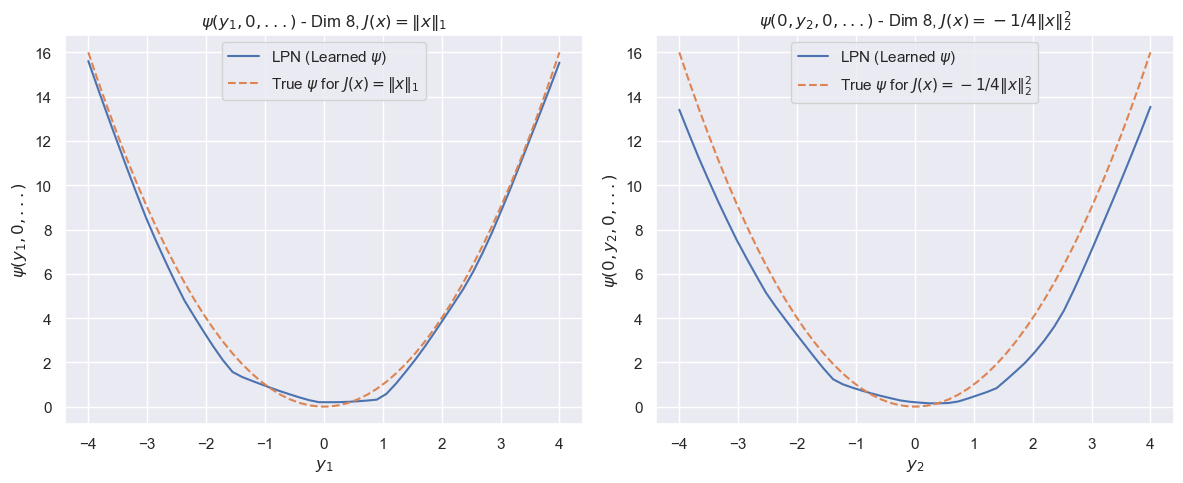

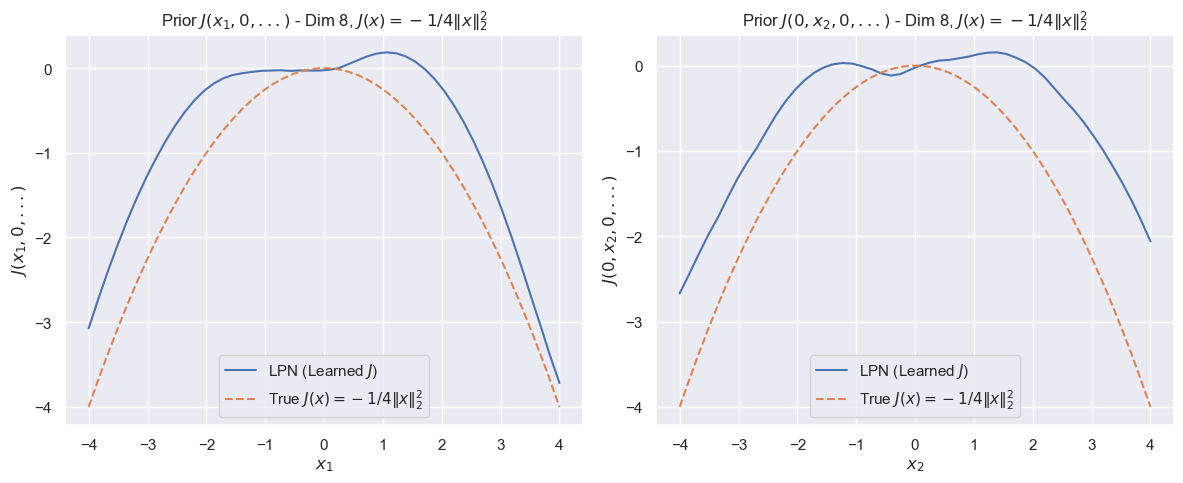

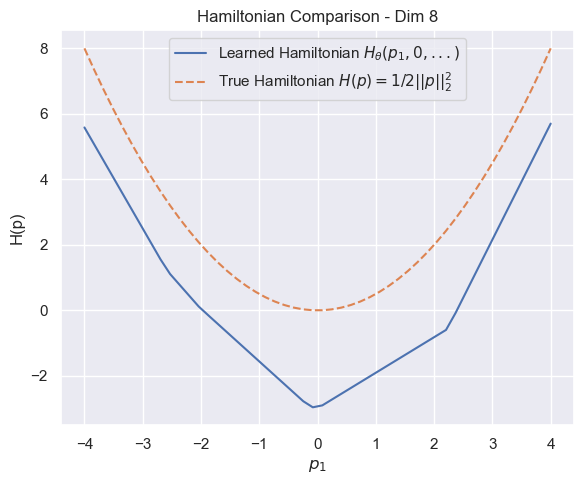

In [54]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)


L1 loss -- Train

In [55]:

# --- Train and Plot with L1 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 1716.781982421875
iteration 500 loss 57.2796516418457
iteration 0 loss 50.239173889160156
iteration 500 loss 47.37931823730469
iteration 1000 loss 45.52526092529297
iteration 1500 loss 43.67805099487305
iteration 2000 loss 41.516929626464844
iteration 2500 loss 38.900352478027344
iteration 3000 loss 35.71980285644531
iteration 3500 loss 31.738388061523438
iteration 4000 loss 26.387752532958984
iteration 4500 loss 18.918107986450195
iteration 5000 loss 10.530226707458496
iteration 5500 loss 5.1482720375061035
iteration 6000 loss 3.2403042316436768
iteration 6500 loss 2.364901065826416
iteration 7000 loss 1.8218618631362915
iteration 7500 loss 1.455742359161377
iteration 8000 loss 1.179888129234314
iteration 8500 loss 0.9732304811477661
iteration 9000 loss 0.807173490524292
iteration 9500 loss 0.678790271282196
iteration 10000 loss 0.5779987573623657
iteration 10500 loss 0.5044967532157898
iteration 11000 lo

L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss 10.221420288085938
loss -42.34965896606445
loss -79.16537475585938
loss -106.81793975830078
loss -117.776123046875
loss -120.44134521484375
loss -120.81919860839844
loss -120.89058685302734
loss -120.91192626953125
loss -120.91587829589844
loss -120.92036437988281
loss -120.92042541503906
loss -120.9212417602539
loss -120.92156982421875
loss -120.92467498779297
loss -120.9240951538086
loss -120.92294311523438
loss -120.9230728149414
loss -120.92497253417969
loss -120.92185974121094
loss -120.92326354980469
loss -120.9228744506836
loss -120.92215728759766
loss -120.92193603515625
loss -120.92391967773438
loss -120.92288208007812
loss -120.92272186279297
loss -120.92318725585938
loss -120.92273712158203
loss -120.92169189453125
loss -120.92352294921875
loss -120.9241943359375
loss -120.92364501953125
loss -120.92393493652344
loss -120.92330932617188
loss -120.9239273071289
loss -120.92130279541016
loss

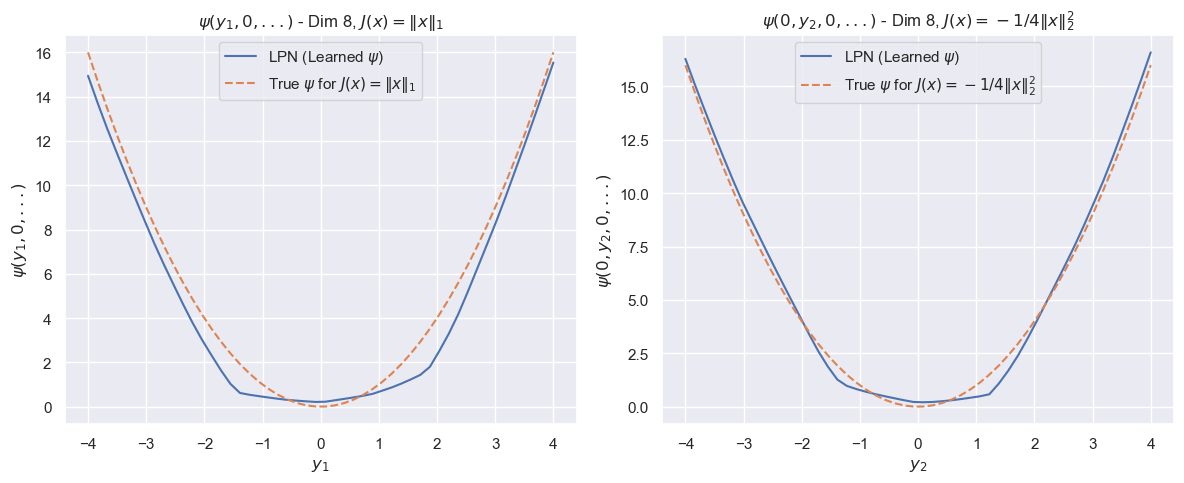

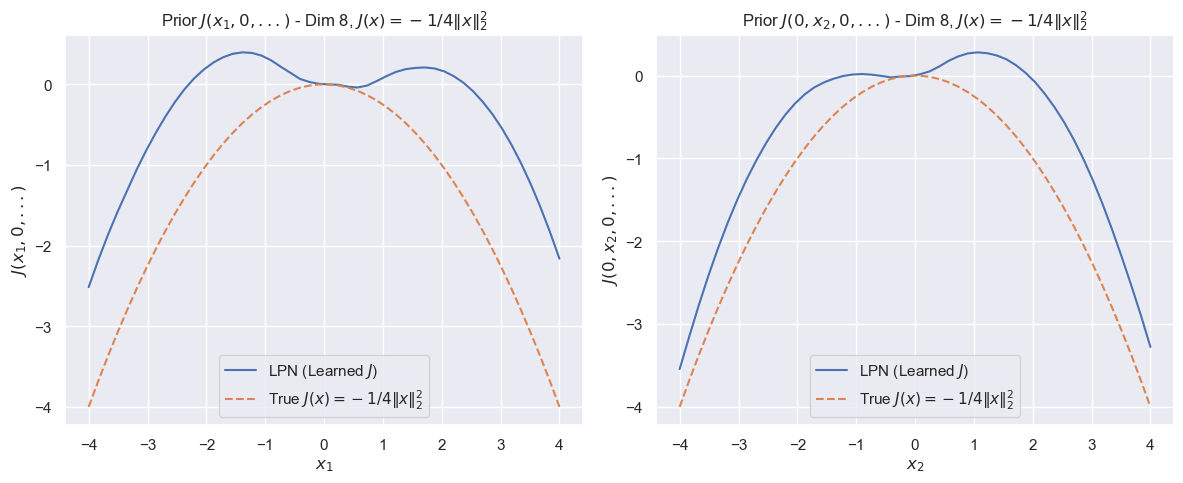

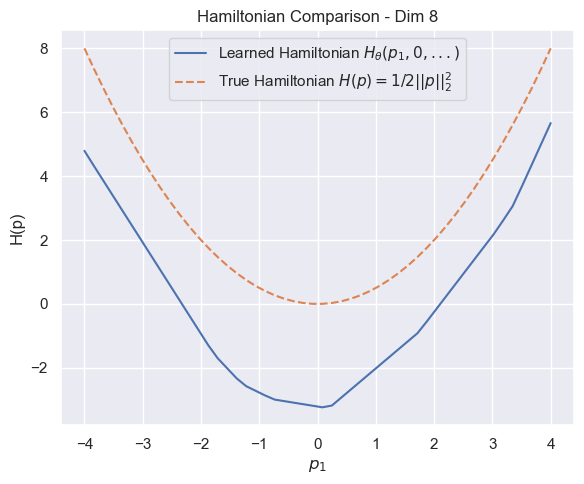

In [56]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [57]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [58]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [59]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [60]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [61]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [62]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)